In [1]:
print('Hello MNIST!')

Hello MNIST!


In [2]:
import numpy as np
import pandas as pd

## 3.1 MNIST

* Download the dataset from [here](https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat)
* See the stackoverflow discussion [here](https://stackoverflow.com/questions/53096977/mnist-data-download-from-sklearn-datasets-gives-timeout-error)

In [3]:
from scipy.io import loadmat
mnist = loadmat('./datasets/mnist-original.mat')

In [4]:
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [5]:
X, y = mnist['data'], mnist['label']

In [6]:
X = X.T
X.shape

(70000, 784)

In [7]:
y = y.T
y.shape

(70000, 1)

In [8]:
type(y)

numpy.ndarray

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

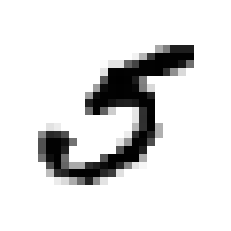

In [10]:
some_digit = X[36000]
some_digit_image = some_digit.reshape((28, 28))
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis('off')
plt.show()

### Split test and training data

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
len(X_train)

60000

In [13]:
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 3.2 Training a binary classifier

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
pd.Series(y_train_5.reshape(len(y_train_5),)).value_counts()

False    54579
True      5421
dtype: int64

In [16]:
y_train_5_0_1 = np.where(y_train_5, 1, 0)
pd.Series(y_train_5_0_1.reshape(len(y_train_5),)).value_counts()

0    54579
1     5421
dtype: int64

In [17]:
from sklearn.linear_model import SGDClassifier

In [18]:
y_train_5 = y_train_5.reshape(len(y_train_5),)
y_train_5.shape

(60000,)

In [19]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
sgd_clf.predict([some_digit])

array([ True])

In [21]:
sgd_clf.predict(some_digit.reshape(1, -1))

array([ True])

In [22]:
some_digit.reshape(1, -1).shape

(1, 784)

## 3.3 Performance Measure

###  3.3.1 Implementing the cross-validation

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [24]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [25]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    X_test_fold   = X_train[test_index]
    y_train_folds = y_train_5[train_index]
    y_test_fold   = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9661
0.94015
0.9652


In [26]:
from sklearn.model_selection import cross_val_score
# cross_val_score(sgd_clf, X_train, y_train_5.reshape(len(y_train_5,)), cv=3, scoring="accuracy")

#### Dummy predictor

In [27]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [28]:
cross_val_score(Never5Classifier(), X_train, y_train_5.reshape(len(y_train_5,)), cv=3, scoring="accuracy")

array([0.9108 , 0.90815, 0.91   ])

### Confusion Matrix

In [29]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5.reshape(len(y_train_5,)), cv=3)

In [30]:
y_train_predict

array([False, False, False, ..., False, False,  True])

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_predict)

array([[52873,  1706],
       [  865,  4556]])

In [32]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [34]:
precision_score(y_train_5, y_train_predict)

0.727563078888534

In [35]:
recall_score(y_train_5, y_train_predict)

0.8404353440324663

In [36]:
f1_score(y_train_5, y_train_predict)

0.7799366601044253

### 3.3.3 Precision Recall Tradeoff

In [37]:
y_scores = sgd_clf.decision_function([some_digit])

In [38]:
np.array_equal(np.where(sgd_clf.decision_function(X_train) < 0, False, True), sgd_clf.predict(X_train))

True

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [40]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [41]:
len(precisions), len(recalls), len(thresholds)

(59978, 59978, 59977)

In [42]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')

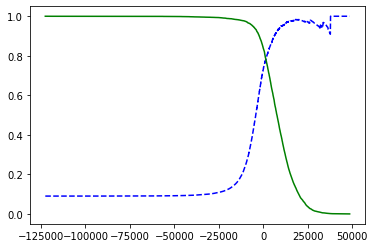

In [43]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

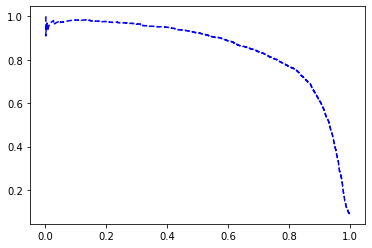

In [44]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b--')
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [45]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [46]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9002019036631094
0.5757240361556908


### 3.3.4 ROC Curve

In [47]:
from sklearn.metrics import roc_curve

In [48]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [49]:
confusion_matrix(y_train_5, y_scores>=0)

array([[52873,  1706],
       [  865,  4556]])

In [50]:
len(fpr), len(thresholds)
fpr[1096], tpr[1096]

(0.013558328294765385, 0.7007932115845785)

In [51]:
4130/(1291+4130), 779 / (53799+780)

(0.7618520568160856, 0.014272888840030048)

In [52]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--')

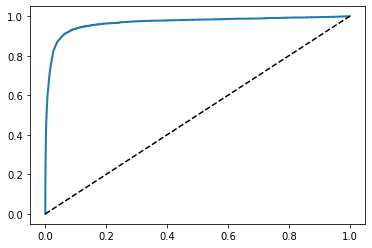

In [53]:
plot_roc_curve(fpr, tpr)

In [54]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9667999648456993

#### `RandomForestClassifier`

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [56]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [57]:
y_scores_froest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_froest)

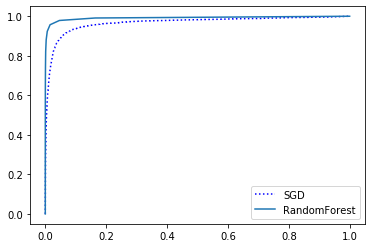

In [58]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plt.plot(fpr_forest, tpr_forest, label='RandomForest')
plt.legend(loc='lower right')

In [59]:
roc_auc_score(y_train_5, y_scores_froest)

0.9920199801158442

In [60]:
precision_score(y_train_5, y_scores_froest>0.5)

0.9847547503314185

In [61]:
recall_score(y_train_5, y_scores_froest>0.5)

0.8221730308061244

## 3.4 Multiclass

In [62]:
sgd_clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [63]:
some_digit_scores = sgd_clf.decision_function([some_digit])

In [64]:
sgd_clf.predict([some_digit])

array([5.])

In [65]:
np.argmax(some_digit_scores)

5

In [66]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

### Manually OVO or OVA

In [67]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

In [68]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

In [69]:
ovo_clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [70]:
ovo_clf.predict([some_digit])

array([5.])

In [71]:
len(ovo_clf.estimators_)

45

In [72]:
forest_clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [73]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [74]:
# Time consuming, skip
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [75]:
from sklearn.preprocessing import StandardScaler

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [77]:
# Time consuming, skip
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## 3.5 Error Analysis

In [78]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train.reshape(len(y_train,)), cv=3)

In [79]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [80]:
conf_mx

array([[5688,    1,   45,   38,   22,   39,   30,    6,   45,    9],
       [   2, 6424,   38,   46,   18,   49,   17,    9,  109,   30],
       [  70,   72, 4918,  379,   81,   52,  116,   64,  172,   34],
       [  22,   19,  111, 5498,   18,  261,   23,   34,   55,   90],
       [  13,   20,   40,   23, 5334,   25,   38,   10,   31,  308],
       [  93,    9,   31,  311,  138, 4533,  106,   14,  102,   84],
       [  54,   14,   93,   24,   59,  140, 5499,    5,   25,    5],
       [  25,   23,   69,   76,  150,   27,    8, 5234,   31,  622],
       [  36,  112,   73,  603,   98,  571,   38,   15, 4019,  286],
       [  41,   16,   30,  140,  798,  100,    2,  172,   39, 4611]])

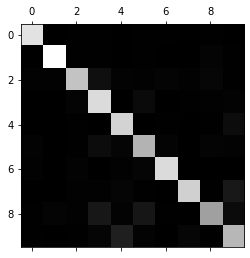

In [83]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [89]:
rowsum = conf_mx.sum(axis=1, keepdims=True)
rowsum

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [90]:
norm_conf_mx = conf_mx / rowsum
norm_conf_mx

array([[9.60324160e-01, 1.68833361e-04, 7.59750127e-03, 6.41566774e-03,
        3.71433395e-03, 6.58450110e-03, 5.06500084e-03, 1.01300017e-03,
        7.59750127e-03, 1.51950025e-03],
       [2.96647879e-04, 9.52832987e-01, 5.63630970e-03, 6.82290122e-03,
        2.66983091e-03, 7.26787303e-03, 2.52150697e-03, 1.33491546e-03,
        1.61673094e-02, 4.44971818e-03],
       [1.17489090e-02, 1.20845921e-02, 8.25444780e-01, 6.36119503e-02,
        1.35951662e-02, 8.72776099e-03, 1.94696207e-02, 1.07418597e-02,
        2.88687479e-02, 5.70661296e-03],
       [3.58832164e-03, 3.09900506e-03, 1.81047137e-02, 8.96754200e-01,
        2.93589953e-03, 4.25705431e-02, 3.75142717e-03, 5.54558800e-03,
        8.97080411e-03, 1.46794976e-02],
       [2.22526532e-03, 3.42348511e-03, 6.84697022e-03, 3.93700787e-03,
        9.13043478e-01, 4.27935638e-03, 6.50462170e-03, 1.71174255e-03,
        5.30640192e-03, 5.27216707e-02],
       [1.71555064e-02, 1.66021029e-03, 5.71850212e-03, 5.73694890e-02,
   

In [92]:
np.fill_diagonal(norm_conf_mx, 0)
norm_conf_mx

array([[0.        , 0.00016883, 0.0075975 , 0.00641567, 0.00371433,
        0.0065845 , 0.005065  , 0.001013  , 0.0075975 , 0.0015195 ],
       [0.00029665, 0.        , 0.00563631, 0.0068229 , 0.00266983,
        0.00726787, 0.00252151, 0.00133492, 0.01616731, 0.00444972],
       [0.01174891, 0.01208459, 0.        , 0.06361195, 0.01359517,
        0.00872776, 0.01946962, 0.01074186, 0.02886875, 0.00570661],
       [0.00358832, 0.00309901, 0.01810471, 0.        , 0.0029359 ,
        0.04257054, 0.00375143, 0.00554559, 0.0089708 , 0.0146795 ],
       [0.00222527, 0.00342349, 0.00684697, 0.00393701, 0.        ,
        0.00427936, 0.00650462, 0.00171174, 0.0053064 , 0.05272167],
       [0.01715551, 0.00166021, 0.0057185 , 0.05736949, 0.02545656,
        0.        , 0.01955359, 0.00258255, 0.01881572, 0.0154953 ],
       [0.0091247 , 0.00236566, 0.01571477, 0.00405542, 0.00996958,
        0.02365664, 0.        , 0.00084488, 0.0042244 , 0.00084488],
       [0.00399042, 0.00367119, 0.0110135

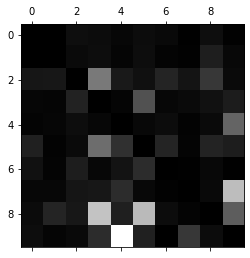

In [93]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [128]:
y_train_pred = y_train_pred.reshape(-1,)
y_train = y_train.reshape(-1,)
y_train.shape, y_train_pred.shape

((60000,), (60000,))

In [129]:
cl_a, cl_5 = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]

NameError: name 'plot_digits' is not defined

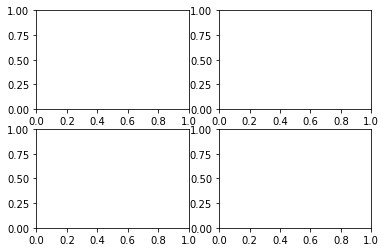

In [133]:
fig, axes = plt.subplots(2, 2)
plt.subplot(2,2,1); plot_digits(X_aa[:25], images_per_row=5)
# https://github.com/ageron/handson-ml/issues/257

In [113]:
X_train_tiny.shape
index_tiny = [True, False, True]

In [125]:
np.asarray(index_tiny).shape

(3,)

In [117]:
?np.ndarray